In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#export
from nb_004 import *

In [3]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'cifar10'

In [4]:
data_mean,data_std = map(tensor, ([0.491, 0.482, 0.447], [0.247, 0.243, 0.261]))
cifar_norm,cifar_denorm = normalize_funcs(data_mean,data_std)

train_tfms = [flip_lr_tfm(p=0.5),
              pad_tfm(padding=4),
              crop_tfm(size=32, row_pct=(0,1.), col_pct=(0,1.))]
valid_tfms = []

bs = 64

## Tweaks to the OptimWrapper to handle an array of lrs/wds/...

In [5]:
#export
def is_listy(x) -> bool: return isinstance(x, (tuple,list))

In [6]:
#export
class OptimWrapper():
    "Basic wrapper around an optimizer to simplify HP changes"
    def __init__(self, opt:optim.Optimizer, wd:Floats=0., true_wd:bool=False):
        self.opt,self.true_wd = opt,true_wd
        self.opt_keys = list(self.opt.param_groups[0].keys())
        self.opt_keys.remove('params')
        self.read_defaults()
        self._wd = self.listify(wd, self.opt.param_groups)
    
    def __repr__(self) -> str:
        return f'OptimWrapper over {repr(self.opt)}.\nTrue weight decay: {self.true_wd}'

    #Pytorch optimizer methods
    def step(self):
        # weight decay outside of optimizer step (AdamW)
        if self.true_wd:
            for lr,wd,pg in zip(self._lr,self._wd,self.opt.param_groups):
                for p in pg['params']: p.data.mul_(1 - wd*lr)
            self.set_val('weight_decay', 0)
        self.opt.step()
    
    def zero_grad(self): self.opt.zero_grad()
    
    #Hyperparameters as properties
    @property
    def lr(self) -> float: return self._lr[-1]

    @lr.setter
    def lr(self, val:float): self._lr = self.set_val('lr', self.listify(val, self._lr))
    
    @property
    def mom(self) -> float: return self._mom[-1]

    @mom.setter
    def mom(self, val:float):
        if 'momentum' in self.opt_keys: self.set_val('momentum', self.listify(val, self._mom))
        elif 'betas' in self.opt_keys:  self.set_val('betas', (self.listify(val, self._mom), self._beta))
        self._mom = self.listify(val, self._mom)
    
    @property
    def beta(self) -> float: return None if self._beta is None else self._beta[-1]

    @beta.setter
    def beta(self, val:float):
        if val is None: return
        if 'betas' in self.opt_keys:    self.set_val('betas', (self._mom, self.listify(val, self._beta)))
        elif 'alpha' in self.opt_keys:  self.set_val('alpha', self.listify(val, self._beta))
        self._beta = self.listify(val, self._beta)
    
    @property
    def wd(self) -> float: return self._wd[-1]

    @wd.setter
    def wd(self, val:float):
        if not self.true_wd: self.set_val('weight_decay', self.listify(val, self._wd))
        self._wd = self.listify(val, self._wd)
    
    #Helper functions
    def read_defaults(self):
        "Read the values inside the optimizer for the hyper-parameters"
        self._beta = None
        if 'lr' in self.opt_keys: self._lr = self.read_val('lr')
        if 'momentum' in self.opt_keys: self._mom = self.read_val('momentum')
        if 'alpha' in self.opt_keys: self._beta = self.read_val('alpha')
        if 'betas' in self.opt_keys: self._mom,self._beta = self.read_val('betas')
        if 'weight_decay' in self.opt_keys: self._wd = self.read_val('weight_decay')
    
    def set_val(self, key:str, val):
        "Set the values inside the optimizer dictionary at the key"
        if is_tuple(val): val = [(v1,v2) for v1,v2 in zip(*val)]
        for v,pg in zip(val,self.opt.param_groups): pg[key] = v
        return val
    
    def read_val(self, key:str) -> Union[List[float],Tuple[List[float],List[float]]]:
        "Read a hyper-parameter key in the optimizer dictionary."
        val = [pg[key] for pg in self.opt.param_groups]
        if is_tuple(val[0]): val = [o[0] for o in val], [o[1] for o in val]
        return val
    
    def listify(self, p, q) -> List[Any]:
        "Wrap listify with an assert."
        if is_listy(p): assert len(p) == len(q), f'Passing {len(p)} hyperparameters when we have {len(q)} groups.'
        return listify(p,q)

In [7]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)

In [8]:
model = model.layers

In [9]:
#export
def split_model(model:nn.Module, idx:Sequence[int]) -> List[nn.Module]:
    "Split the model according to the layers index in idx"
    layers = list(model.children())
    if idx[0] != 0: idx = [0] + idx
    if idx[-1] != len(layers): idx.append(len(layers))
    return [nn.Sequential(*layers[i:j]) for i,j in zip(idx[:-1],idx[1:])]

In [10]:
split_model(model, [5])

[Sequential(
   (0): Sequential(
     (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): LeakyReLU(negative_slope=0.1, inplace)
   )
   (1): Sequential(
     (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): LeakyReLU(negative_slope=0.1, inplace)
   )
   (2): ResLayer(
     (conv1): Sequential(
       (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): LeakyReLU(negative_slope=0.1, inplace)
     )
     (conv2): Sequential(
       (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (

In [11]:
layer_groups = split_model(model, [5,9])
layer_groups

[Sequential(
   (0): Sequential(
     (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): LeakyReLU(negative_slope=0.1, inplace)
   )
   (1): Sequential(
     (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): LeakyReLU(negative_slope=0.1, inplace)
   )
   (2): ResLayer(
     (conv1): Sequential(
       (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): LeakyReLU(negative_slope=0.1, inplace)
     )
     (conv2): Sequential(
       (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (

In [12]:
lrs = [1e-3,1e-2,0.1]

In [13]:
tst_opt = OptimWrapper(optim.SGD([{'params':l.parameters(), 'lr':lr} for l,lr in zip(layer_groups, lrs)]))

In [14]:
tst_opt.lr, tst_opt._lr

(0.1, [0.001, 0.01, 0.1])

In [15]:
tst_opt.wd, tst_opt._wd

(0.0, [0.0, 0.0, 0.0])

In [16]:
tst_opt.wd = [0.1,0.1]

AssertionError: Passing 2 hyperparameters when we have 3 groups.

## Now let's tweak the learner to handle this.

In [17]:
#export
@dataclass
class Learner():
    "Object that wraps together some data, a model, a loss function and an optimizer"
    
    data:DataBunch
    model:nn.Module
    opt_fn:Callable=optim.SGD
    loss_fn:Callable=F.cross_entropy
    metrics:Collection[Callable]=None
    true_wd:bool=False
    layer_groups:Collection[nn.Module]=None
    def __post_init__(self): 
        self.model = self.model.to(self.data.device)
        self.callbacks = []

    def fit(self, epochs:int, lr:Floats, wd:Floats=0., callbacks:Collection[Callback]=None):
        if not hasattr(self, 'opt'): self.create_opt(lr, wd)
        else: self.opt.wd = wd
        if callbacks is None: callbacks = []
        callbacks = self.callbacks + callbacks
        fit(epochs, self.model, self.loss_fn, self.opt, self.data, callbacks=callbacks, metrics=self.metrics)
    
    def create_opt(self, lr:Floats, wd:Floats=0.):
        if self.layer_groups is None: self.layer_groups = [self.model]
        lrs = listify(lr, self.layer_groups)
        opt = self.opt_fn([{'params':l.parameters(), 'lr':lr} for l,lr in zip(self.layer_groups, lrs)])
        self.opt = OptimWrapper(opt, wd=wd, true_wd=self.true_wd)
        self.recorder = Recorder(self.opt, self.data.train_dl)
        self.callbacks = [self.recorder] + self.callbacks

In [18]:
train_ds = FilesDataset.from_folder(PATH/'train', classes=['airplane','dog'])
valid_ds = FilesDataset.from_folder(PATH/'test', classes=['airplane','dog'])
data = DataBunch.create(train_ds, valid_ds, bs=bs, train_tfm=train_tfms, valid_tfm=valid_tfms, num_workers=4, dl_tfms=cifar_norm)
len(data.train_dl), len(data.valid_dl)

(157, 16)

In [19]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)
layer_groups = split_model(model.layers, [5,9])
learn = Learner(data, model)
learn.metrics = [accuracy]
learn.layer_groups = layer_groups

In [20]:
learn.fit(1, lrs)

0 0.3017129672713558 0.3208229525089264 0.8665



In [21]:
learn.opt._lr

[0.001, 0.01, 0.1]

In [22]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)
learn = Learner(data, model)
learn.metrics = [accuracy]

In [23]:
learn.fit(1,0.1)

0 0.31156843669621226 0.6305722761154174 0.7560000004768371



In [24]:
learn.opt._lr

[0.1]

In [25]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)
learn = Learner(data, model)
learn.metrics = [accuracy]
learn.layer_groups = split_model(model.layers, [5,9])

In [26]:
learn.fit(1, lrs, wd=[1e-4,1e-3,1e-2])

0 0.26014404467370883 0.3191265777349472 0.8980000009536743



In [27]:
learn.opt._wd

[0.0001, 0.001, 0.01]

In [28]:
learn.fit(1, lrs, wd=[1e-4,1e-3])

AssertionError: Passing 2 hyperparameters when we have 3 groups.

LRs and WDs are the easiest to pass through the Learner, but if a Callback sets an array of moms or betas, the OptimWrapper will handle them as discriminative moms/betas.

## See how it fits with the other callbacks

In [29]:
lrs = np.array(lrs)

In [30]:
lr_find(learn, start_lr=lrs/1000, end_lr=lrs*100)

0 0.49099073502684004
0 0.49099073502684004


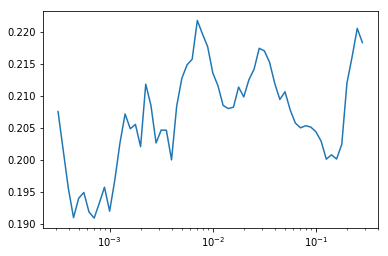

In [31]:
learn.recorder.plot()

In [32]:
sched = OneCycleScheduler(learn, lrs, 1)
learn.fit(1, lrs, callbacks=[sched])

0 0.47375124088314624 0.29985523176193235 0.8750000014305115
0 0.47375124088314624 0.29985523176193235 0.8750000014305115
